In [2]:
import numpy as np
import pandas as pd
import os

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from scipy.special import rel_entr
from scipy.stats import entropy
import scipy.stats
import math
import warnings 
warnings.filterwarnings("ignore") 

In [3]:
# 使用GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [4]:
! nvidia-smi

Sun Jun 12 18:51:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 30%   39C    P8    21W / 260W |     22MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 29%   

# MongoDB

In [5]:
from pymongo import MongoClient
import pymongo

In [6]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_de = db.patent_de
    # db_us = db.patent_us
    # db_cn = db.patent_cn

    db_rm_cn_2014 = db.rm_patent_cn_2014
    db_rm_us_2014 = db.rm_patent_us_2014
    db_rm_de_2014 = db.rm_patent_de_2014

    
except errors.ConnectionFailure as err:
    print(err)

# 2014

## Company數量

In [7]:
data_assignee = db_rm_de_2014.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])

In [8]:
df_family_de = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [9]:
data_assignee = db_rm_cn_2014.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_cn = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [10]:
data_assignee = db_rm_us_2014.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_us = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [11]:
final_df = pd.concat([df_family_de,df_family_cn,df_family_us],axis=0)

In [12]:
# 取總數前15家公司
final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)

,company,count
11,Cisco Technology Inc,85
30,Intel Corp,70
46,Qualcomm Inc,65
41,Nanjing IoT Sensor Technology Co Ltd,63
36,Jiangsu IoT Research and Development Center,54
58,Telefonaktiebolaget LM Ericsson AB,40
52,Samsung Electronics Co Ltd,24
12,Convida Wireless LLC,21
55,Suzhou Hickman IOT Technology Co. Ltd.,18
38,LG Electronics Inc,18


In [13]:
com_df = final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)
com_df.reset_index(drop=True, inplace=True)

In [14]:
com_df["count_log"] = com_df["count"].apply(lambda x: np.log(x))
com_df

,company,count,count_log
0,Cisco Technology Inc,85,4.442651
1,Intel Corp,70,4.248495
2,Qualcomm Inc,65,4.174387
3,Nanjing IoT Sensor Technology Co Ltd,63,4.143135
4,Jiangsu IoT Research and Development Center,54,3.988984
5,Telefonaktiebolaget LM Ericsson AB,40,3.688879
6,Samsung Electronics Co Ltd,24,3.178054
7,Convida Wireless LLC,21,3.044522
8,Suzhou Hickman IOT Technology Co. Ltd.,18,2.890372
9,LG Electronics Inc,18,2.890372


In [15]:
com_ls = list(com_df.company)

## Data

In [16]:
ccontry = pd.read_csv("./final_data/rm_company_country_all_2014.csv")
ccpc = pd.read_csv("./final_data/rm_company_cpc_all_2014.csv")

In [17]:
ccontry[ccontry.company.isin(com_ls)].head()

,company,AR,AT,AU,BR,CA,CL,CN,CY,DE,...,PT,RS,RU,SE,SG,SI,TW,UA,US,ZA
53,Belkin International Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
101,Cisco Technology Inc,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0,0.0
108,Convida Wireless LLC,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,0.0
230,Intel Corp,0.0,0.0,0.0,6.0,0.0,0.0,34.0,0.0,3.0,...,0.0,0.0,0.0,0.0,2.0,0.0,24.0,0.0,73.0,0.0
265,Jiangsu IoT Research and Development Center,0.0,0.0,0.0,0.0,0.0,0.0,75.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
ccpc.iloc[378,0]="Zhuhai Youte Iot Technology Co Ltd"

In [19]:
ccpc

,company,A01,A23,A42,A47,A61,A63,B01,B03,B05,...,G11,G16,H01,H02,H03,H04,H05,Y02,Y04,Y10
0,3M innovation intellectual property Co.,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AFI Licensing LLC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
2,AFIRMA CONSULTING & TECHNOLOGIES SL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0
3,ANHUI LIYUAN CNC BLADE MOLD MANUFACTURING Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ANHUI YONGDA IOT Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,ZTE Intelligent IoT Technology Co Ltd,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,6.0,0.0,1.0,0.0,0.0
375,ZTE TX Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0
376,Zenith Steel Group Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
377,Zhongke Rongtong Wulian Technology Wuxi Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Similarity計算

### Country

- 換成機率  

In [20]:
ccontry.set_index("company", inplace=True)
ccontry2 = ccontry.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

### PBC
- 和Samsung Electronics Co Ltd比較

In [21]:
ccontry_pbc = ccontry2.loc[com_ls,:].copy()
ccontry_pbc.head()

,AR,AT,AU,BR,CA,CL,CN,CY,DE,DK,...,PT,RS,RU,SE,SG,SI,TW,UA,US,ZA
company,,,,,,,,,,,,,,,,,,,,,
Cisco Technology Inc,0.0,0.0,0.007874,0.000000,0.000000,0.0,0.031496,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.685039,0.0
Intel Corp,0.0,0.0,0.000000,0.028846,0.000000,0.0,0.163462,0.0,0.014423,0.0,...,0.0,0.000000,0.0,0.0,0.009615,0.0,0.115385,0.0,0.350962,0.0
Qualcomm Inc,0.0,0.0,0.000000,0.029412,0.006536,0.0,0.179739,0.0,0.000000,0.0,...,0.0,0.003268,0.0,0.0,0.000000,0.0,0.032680,0.0,0.205882,0.0
Nanjing IoT Sensor Technology Co Ltd,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
Jiangsu IoT Research and Development Center,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0


In [22]:
def PBC(a,b):
    return sum(a*b)

ccontry_pbc["sum"] = ccontry_pbc.apply(lambda x: PBC(ccontry_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

### CPC

In [23]:
ccpc.set_index("company", inplace=True)
ccpc2 = ccpc.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [24]:
ccpc2

,A01,A23,A42,A47,A61,A63,B01,B03,B05,B09,...,G11,G16,H01,H02,H03,H04,H05,Y02,Y04,Y10
company,,,,,,,,,,,,,,,,,,,,,
3M innovation intellectual property Co.,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
AFI Licensing LLC,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.272727
AFIRMA CONSULTING & TECHNOLOGIES SL,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.000000,0.0,0.000000
ANHUI LIYUAN CNC BLADE MOLD MANUFACTURING Co Ltd,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
ANHUI YONGDA IOT Co Ltd,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.166667,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTE Intelligent IoT Technology Co Ltd,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.136364,0.0,0.272727,0.0,0.045455,0.0,0.000000
ZTE TX Inc,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.666667,0.0,0.333333,0.0,0.000000
Zenith Steel Group Co Ltd,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.000000,0.0,0.000000


In [25]:
ccpc_pbc = ccpc2.loc[com_ls,:].copy()
# ccpc_pbc

In [26]:
def PBC(a,b):
    return sum(a*b)

ccpc_pbc["sum"] = ccpc_pbc.apply(lambda x: PBC(ccpc_pbc.loc["Samsung Electronics Co Ltd",:],x), axis=1)

## Scatter Plot

In [27]:
# loop test
def scatter_plot(pbc_n,cpc_n):
    # PBC
    pbc_ls=[]
    n = pbc_n
    for i in ccontry_pbc.index:
        pbc = ccontry_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccontry_pbc["pbc"]=pbc_ls
    
    # CPC
    pbc_ls=[]
    n = cpc_n
    for i in ccpc_pbc.index:
        pbc = ccpc_pbc.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pbc_ls.append(pbc[0])

    ccpc_pbc["pbc"]=pbc_ls
    
    c_df = pd.DataFrame((zip(list(ccpc_pbc["pbc"]), list(ccontry_pbc["pbc"]))), columns = ['cpc', 'country'])
    c_df.set_index(ccpc_pbc.index, inplace=True)

    return c_df

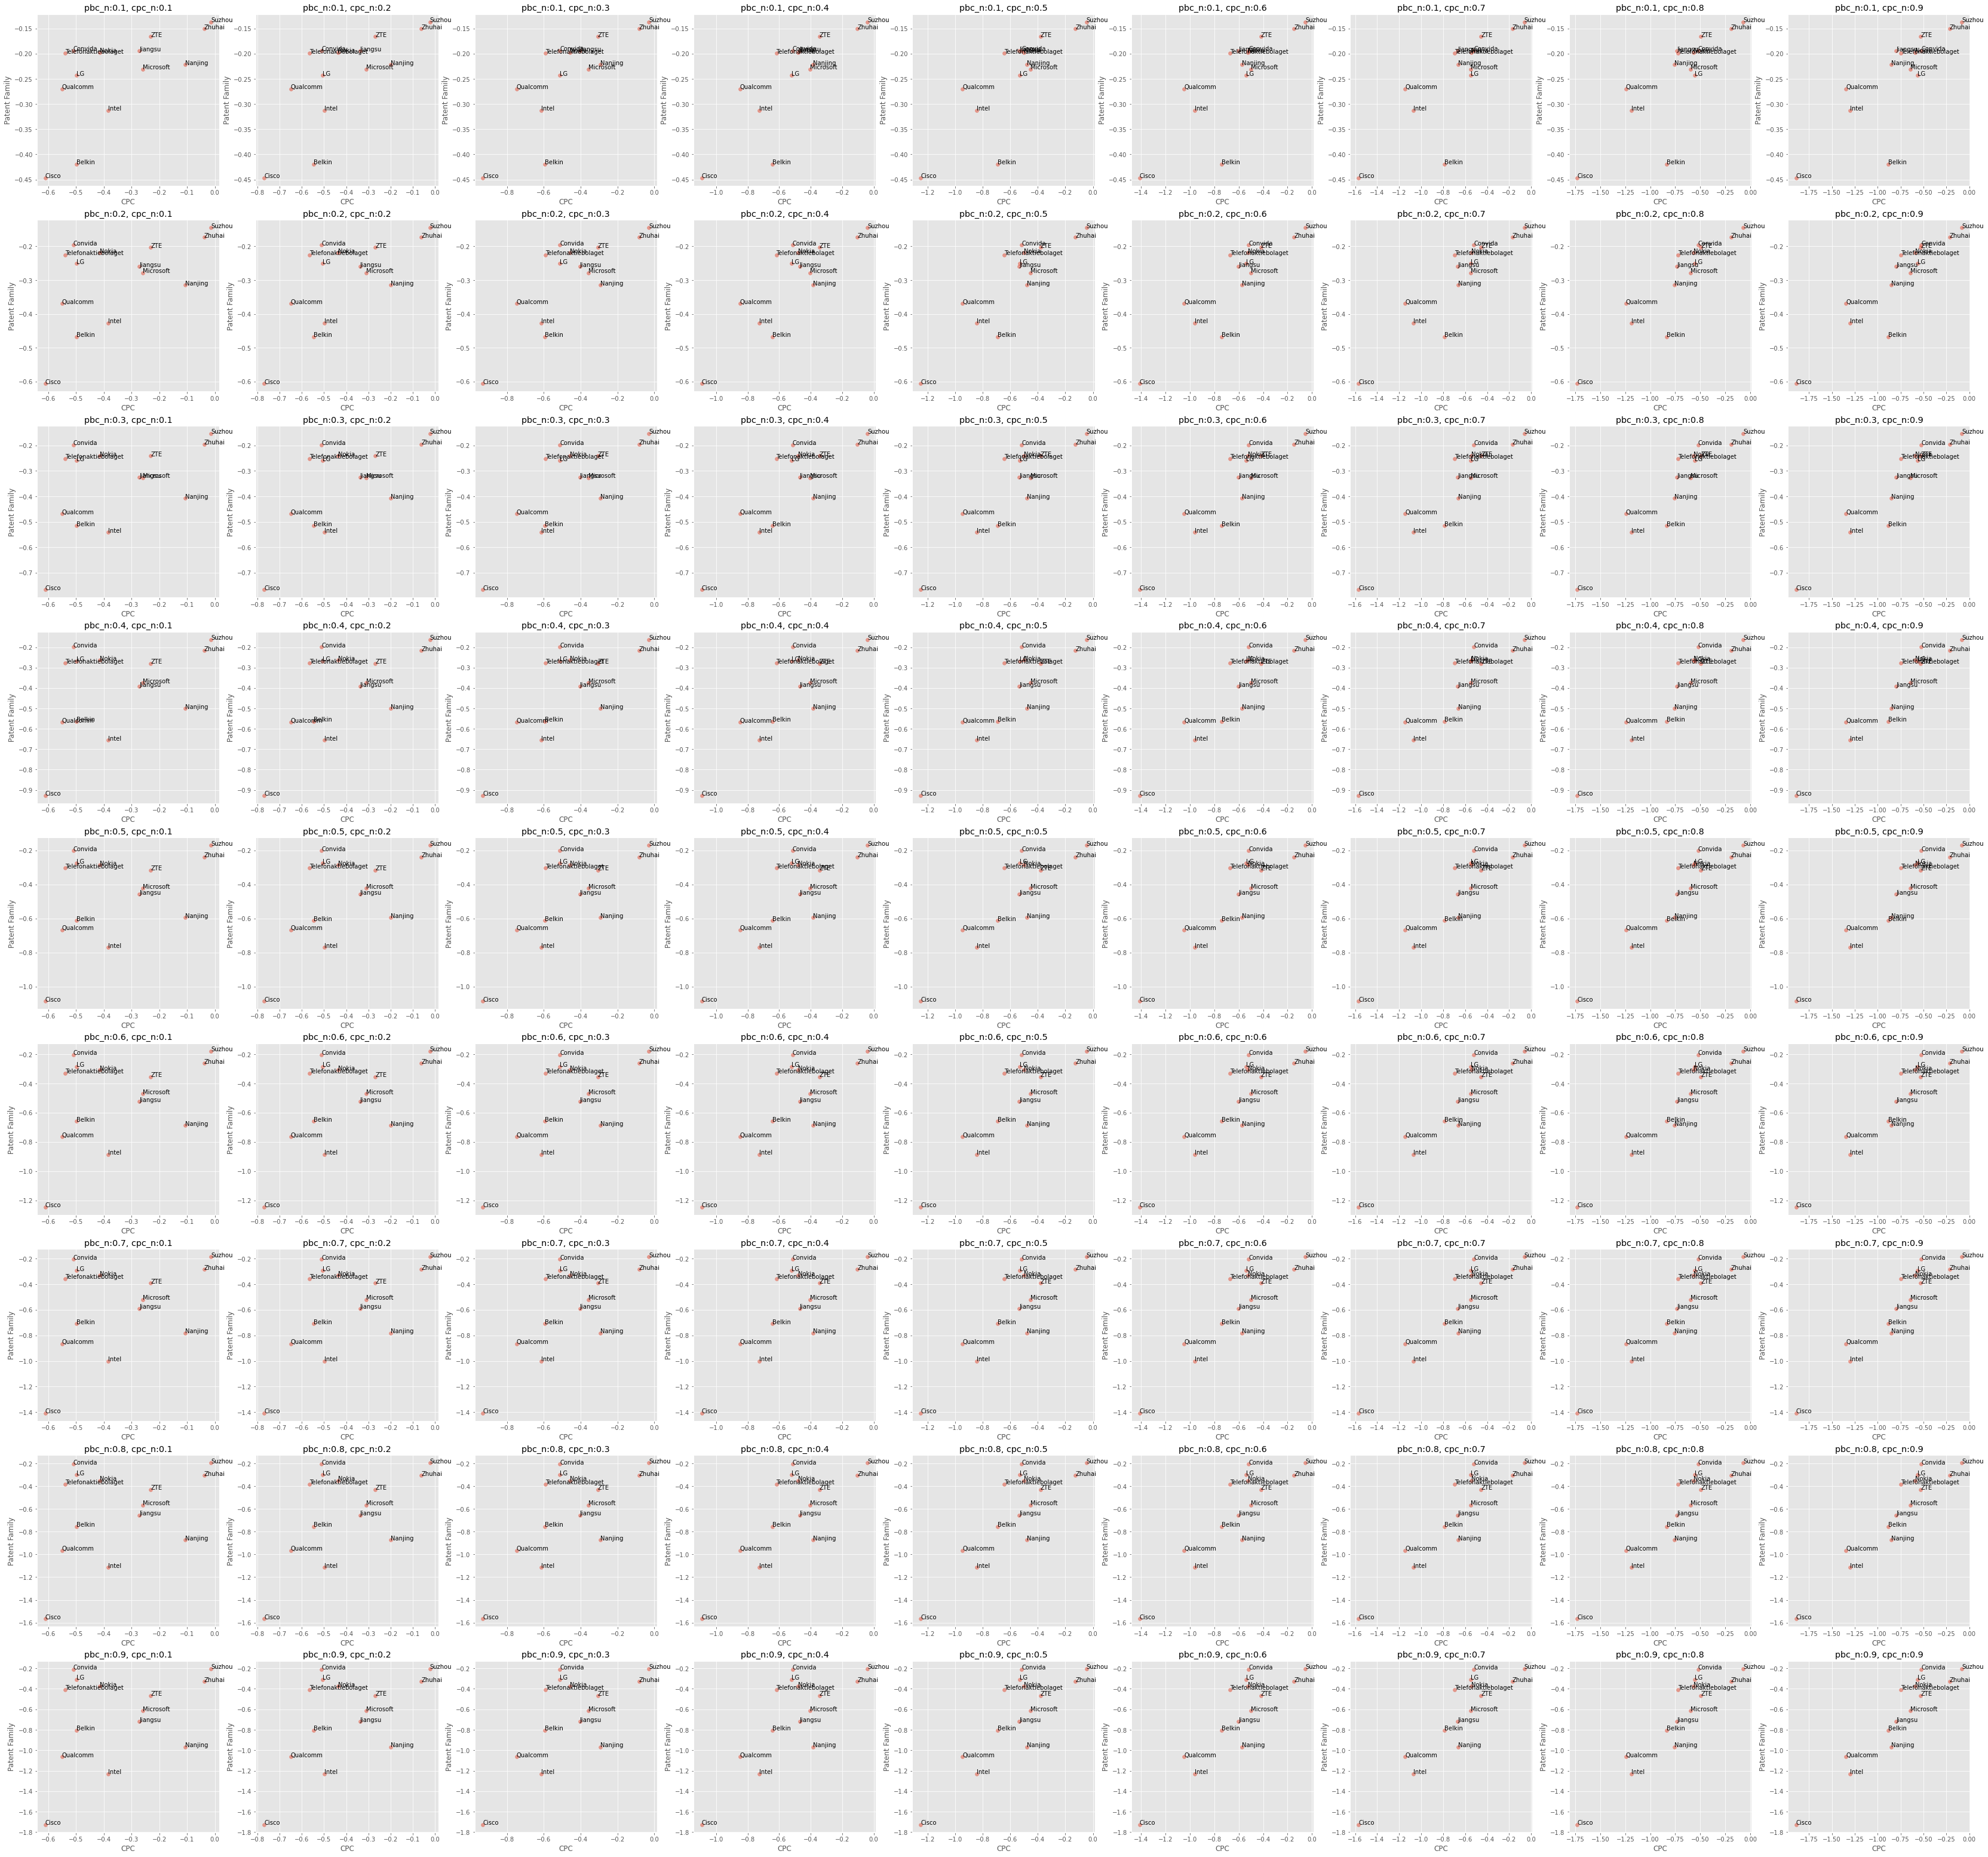

In [28]:
pbc_n_ls=np.arange(0.1,1,0.1)
cpc_n_ls=np.arange(0.1,1,0.1)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_all_2014_1.png'.format(pbc_n))

In [29]:
c_df

,cpc,country
company,,
Cisco Technology Inc,1.890248,1.726013
Intel Corp,1.300782,1.229063
Qualcomm Inc,1.344516,1.063860
Nanjing IoT Sensor Technology Co Ltd,0.851921,0.966814
Jiangsu IoT Research and Development Center,0.798230,0.720418
Telefonaktiebolaget LM Ericsson AB,0.748357,0.408196
Convida Wireless LLC,0.524242,0.208344
Suzhou Hickman IOT Technology Co. Ltd.,0.079804,0.203056
LG Electronics Inc,0.564606,0.309149


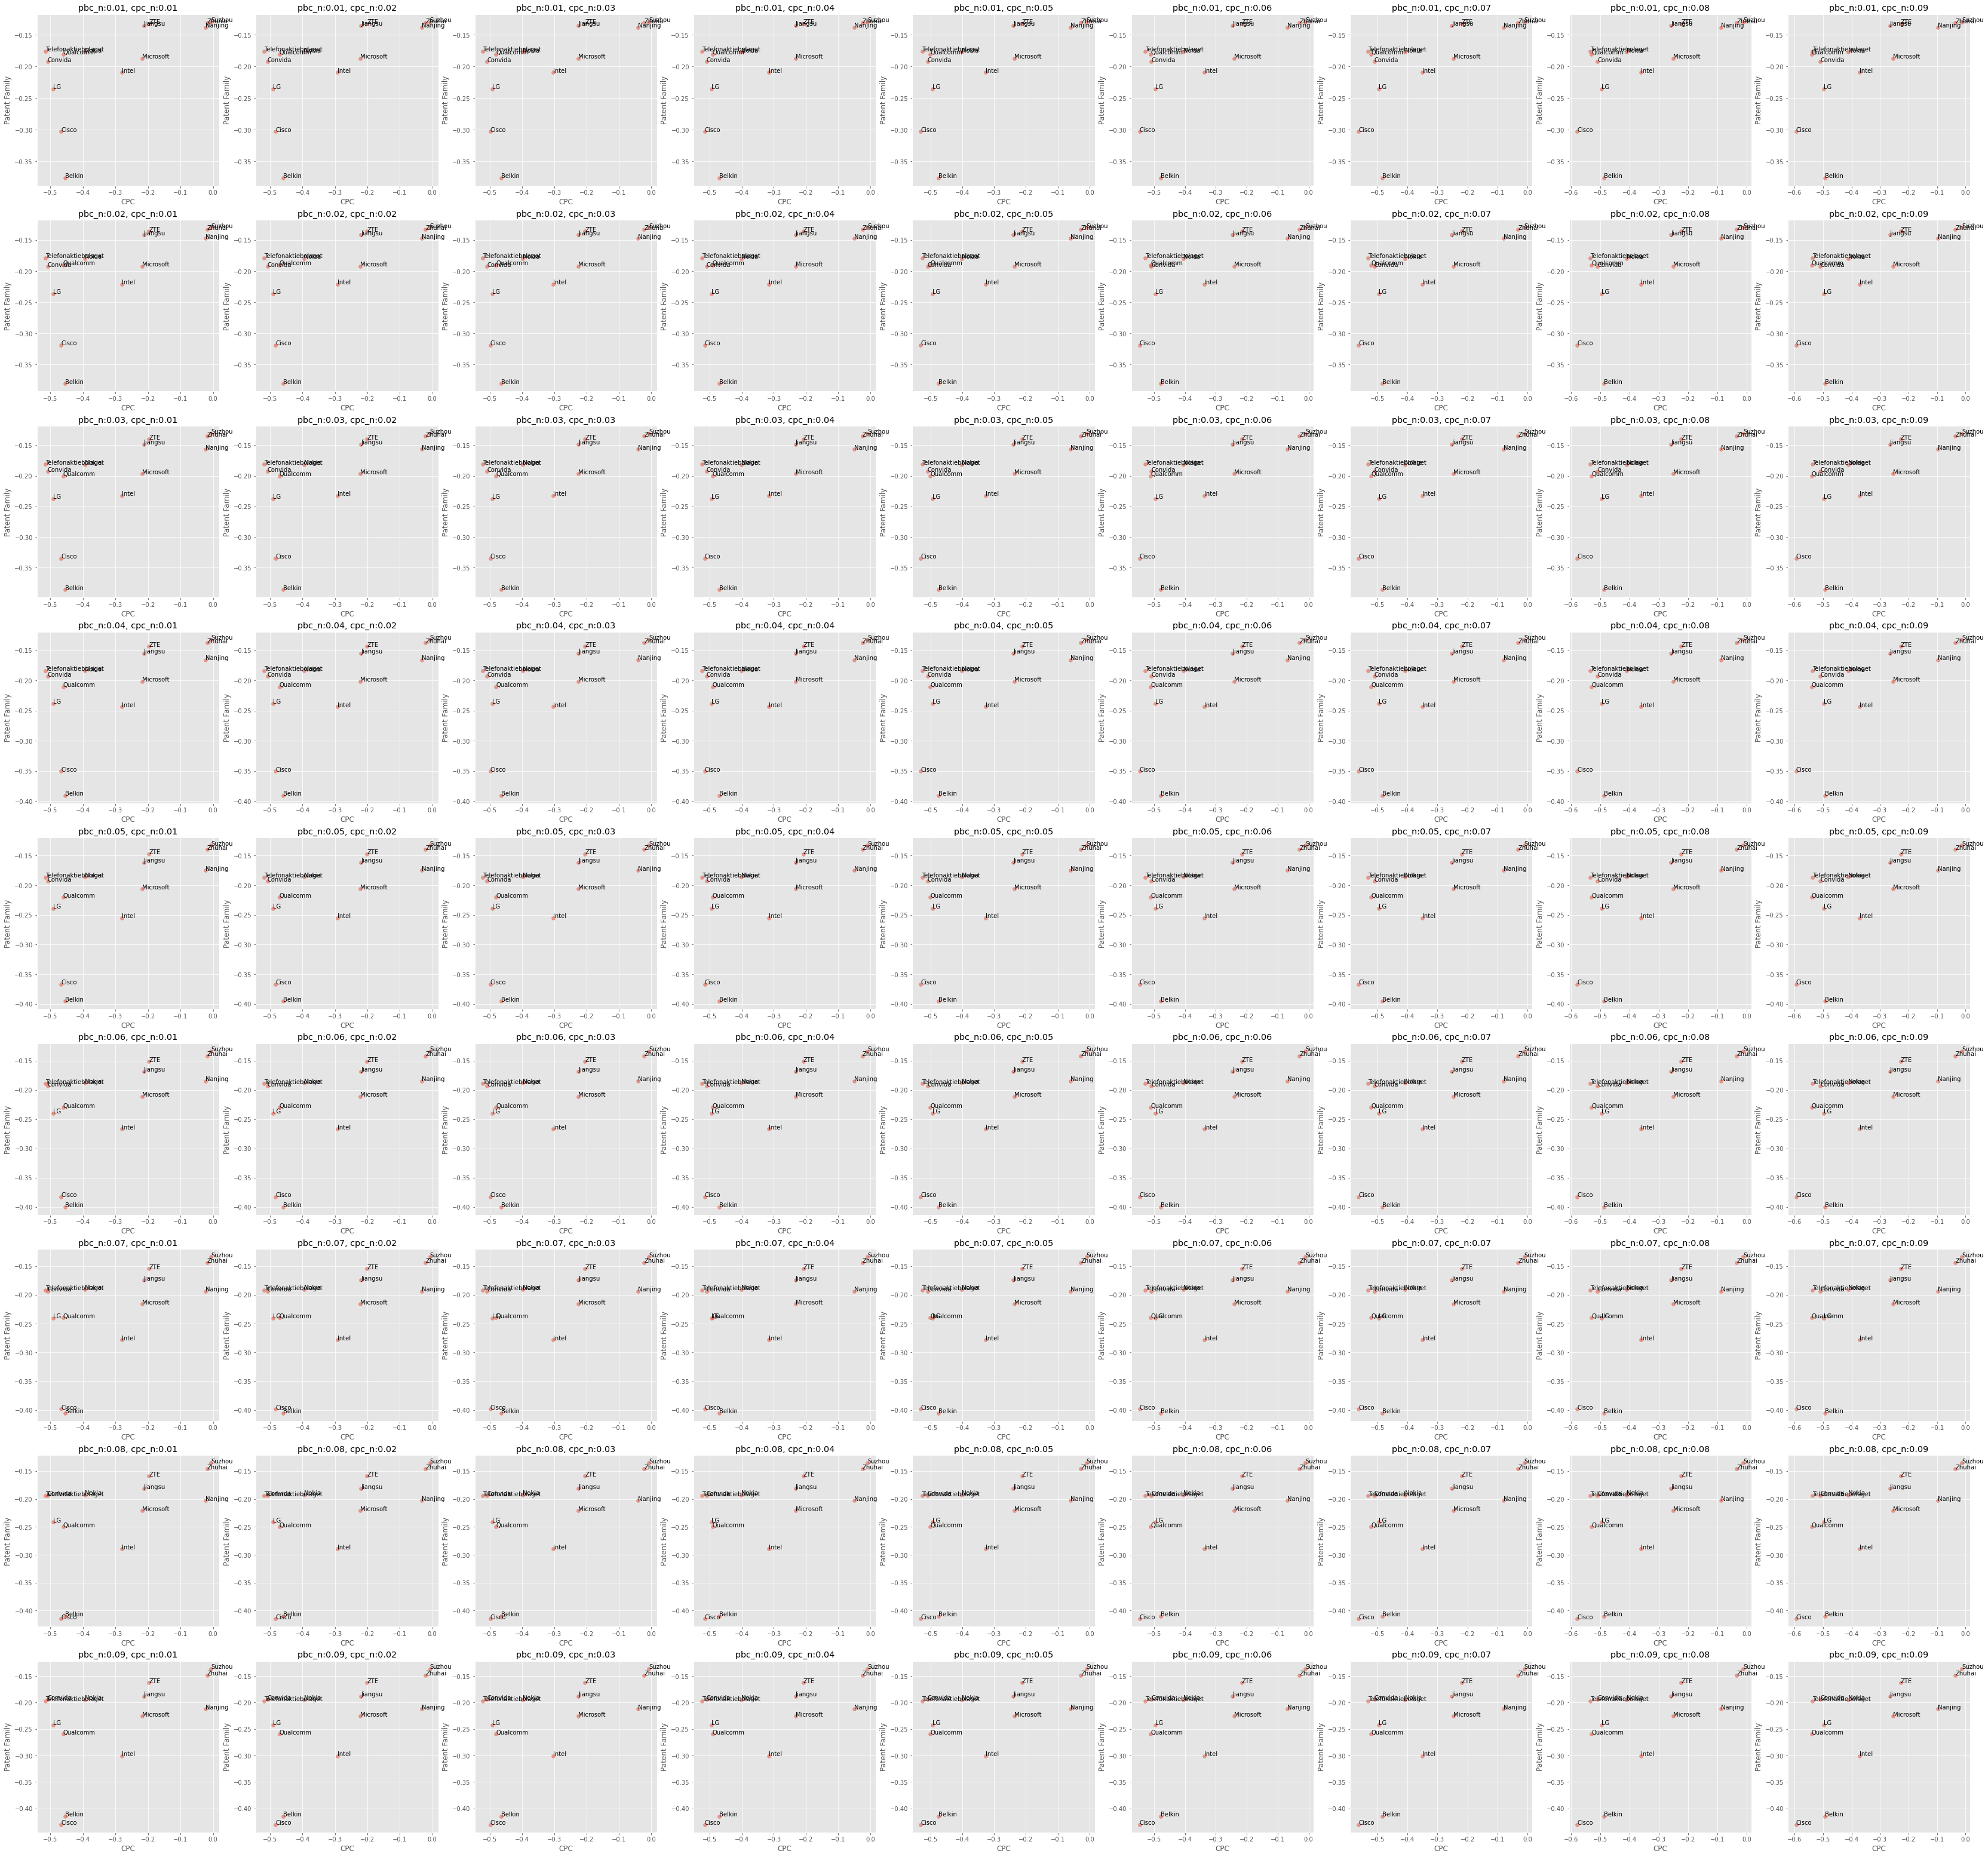

In [30]:
pbc_n_ls=np.arange(0.01,0.1,0.01)
cpc_n_ls=np.arange(0.01,0.1,0.01)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pbc_n in enumerate(pbc_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pbc_n,cpc_n)
        c_df = scatter_plot(pbc_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/plot_all_2014_2.png'.format(pbc_n))

In [31]:
c_df

,cpc,country
company,,
Cisco Technology Inc,0.594891,0.430655
Intel Corp,0.372648,0.300928
Qualcomm Inc,0.540445,0.259789
Nanjing IoT Sensor Technology Co Ltd,0.097502,0.212396
Jiangsu IoT Research and Development Center,0.265568,0.187756
Telefonaktiebolaget LM Ericsson AB,0.536994,0.196832
Convida Wireless LLC,0.509799,0.193902
Suzhou Hickman IOT Technology Co. Ltd.,0.012768,0.136020
LG Electronics Inc,0.497570,0.242112


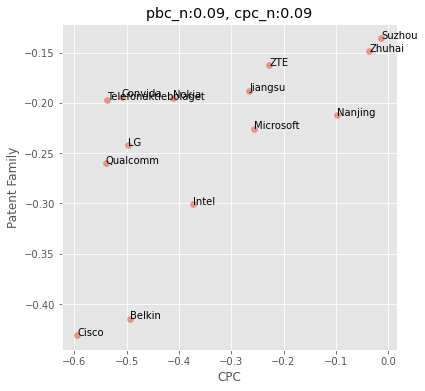

In [32]:
plt.figure(figsize=(6,6))
plt.style.use('ggplot')
c_df = scatter_plot(0.09,0.09)
c_df = c_df.drop("Samsung Electronics Co Ltd")

#plot
# plt.subplot(len(pbc_n_ls), len(cpc_n_ls), n + 1)
plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
plt.title("pbc_n:{}, cpc_n:{}".format(round(pbc_n,2),round(cpc_n,2)))
plt.xlabel("CPC")
plt.ylabel("Patent Family")

for i, txt in enumerate(c_df.index):
    plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

In [33]:
m_x = (-max(c_df.cpc)-min(c_df.cpc))/2
m_y = (-max(c_df.country)-min(c_df.country))/2

competitor_ls = []

for i,cpc,con in zip(c_df.index,c_df["cpc"],c_df["country"]):
    if -cpc>m_x and -con>m_y:
        competitor_ls.append(1)
    elif -cpc<m_x and -con>m_y:
        competitor_ls.append(2)
    elif -cpc>m_x and -con<m_y:
        competitor_ls.append(3)
    else:
        competitor_ls.append(4)

In [36]:
competitor_ls

[4, 4, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 4]

In [35]:
c_df

,cpc,country
company,,
Cisco Technology Inc,0.594891,0.430655
Intel Corp,0.372648,0.300928
Qualcomm Inc,0.540445,0.259789
Nanjing IoT Sensor Technology Co Ltd,0.097502,0.212396
Jiangsu IoT Research and Development Center,0.265568,0.187756
Telefonaktiebolaget LM Ericsson AB,0.536994,0.196832
Convida Wireless LLC,0.509799,0.193902
Suzhou Hickman IOT Technology Co. Ltd.,0.012768,0.136020
LG Electronics Inc,0.497570,0.242112
